In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import json
import importlib
import math



try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm
import utils
from utils import *

# importlib.reload(utils)


# 2. set up for using GPU if available (with printed confirmation)  
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 3. checking environment 
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

Using cuda device


In [2]:
# get data

batch_size = 64

torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
45000
5000
10000


In [15]:
# NEW FUNCS FOR ACTUAL EPISODE GRADIENT ACCUMULATION

def collect_gradients(model, dataloader, device, criterion, optimizer, num_epochs):
    first_5_episodes_gradients = {name: [] for name, _ in model.named_parameters()}
    last_5_episodes_gradients = {name: [] for name, _ in model.named_parameters()}
    
    for epoch in range(num_epochs):
        print('epoch', epoch)
        model.train().to(device)
        
        for batch_count, (images, labels) in enumerate(dataloader, 1):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            episode_gradients = {}
            for name, param in model.named_parameters():
                if param.grad is not None:
                    episode_gradients[name] = param.grad.clone().detach()
            
            if epoch == 0 and batch_count <= 5:
                for name, grad in episode_gradients.items():
                    first_5_episodes_gradients[name].append(grad)
            elif epoch == num_epochs - 1 and batch_count > len(dataloader) - 5:
                for name, grad in episode_gradients.items():
                    last_5_episodes_gradients[name].append(grad)
            
            optimizer.step()
    
    return first_5_episodes_gradients, last_5_episodes_gradients

def compute_gradient_statistics(gradients):
    mean_gradients = {}
    std_gradients = {}

    for layer_name, layer_gradients in gradients.items():
        layer_gradients = torch.stack(layer_gradients)
        mean_gradients[layer_name] = torch.mean(layer_gradients, dim=0)
        std_gradients[layer_name] = torch.std(layer_gradients, dim=0)

    return mean_gradients, std_gradients


def plot_gradient_statistics(mean_gradients_first5, std_gradients_first5, mean_gradients_last5, std_gradients_last5):
    num_layers = len(mean_gradients_first5)
    layer_names = list(mean_gradients_first5.keys())
    x = np.arange(num_layers)
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Gradient Statistics', fontsize=16)

    # Plot mean gradients
    ax1.bar(x - width/2, [torch.mean(mean_gradients_first5[name]).item() for name in layer_names], width, label='First 5 Epochs')
    ax1.bar(x + width/2, [torch.mean(mean_gradients_last5[name]).item() for name in layer_names], width, label='Last 5 Epochs')
    ax1.set_xticks(x)
    ax1.set_xticklabels(layer_names, rotation=90)
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Mean Gradient')
    ax1.set_title('Mean Gradient vs Layer')
    ax1.legend()
    ax1.ticklabel_format(style='plain', axis='y')  # Show true values on y-axis

    # Plot standard deviations
    ax2.bar(x - width/2, [torch.mean(std_gradients_first5[name]).item() for name in layer_names], width, label='First 5 Epochs')
    ax2.bar(x + width/2, [torch.mean(std_gradients_last5[name]).item() for name in layer_names], width, label='Last 5 Epochs')
    ax2.set_xticks(x)
    ax2.set_xticklabels(layer_names, rotation=90)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Standard Deviation of Gradient')
    ax2.set_title('Standard Deviation of Gradient vs Layer')
    ax2.legend()
    ax2.ticklabel_format(style='plain', axis='y')  # Show true values on y-axis

    plt.tight_layout()
    plt.show()


In [16]:
num_epochs = 30
learning_rate= 0.05

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29


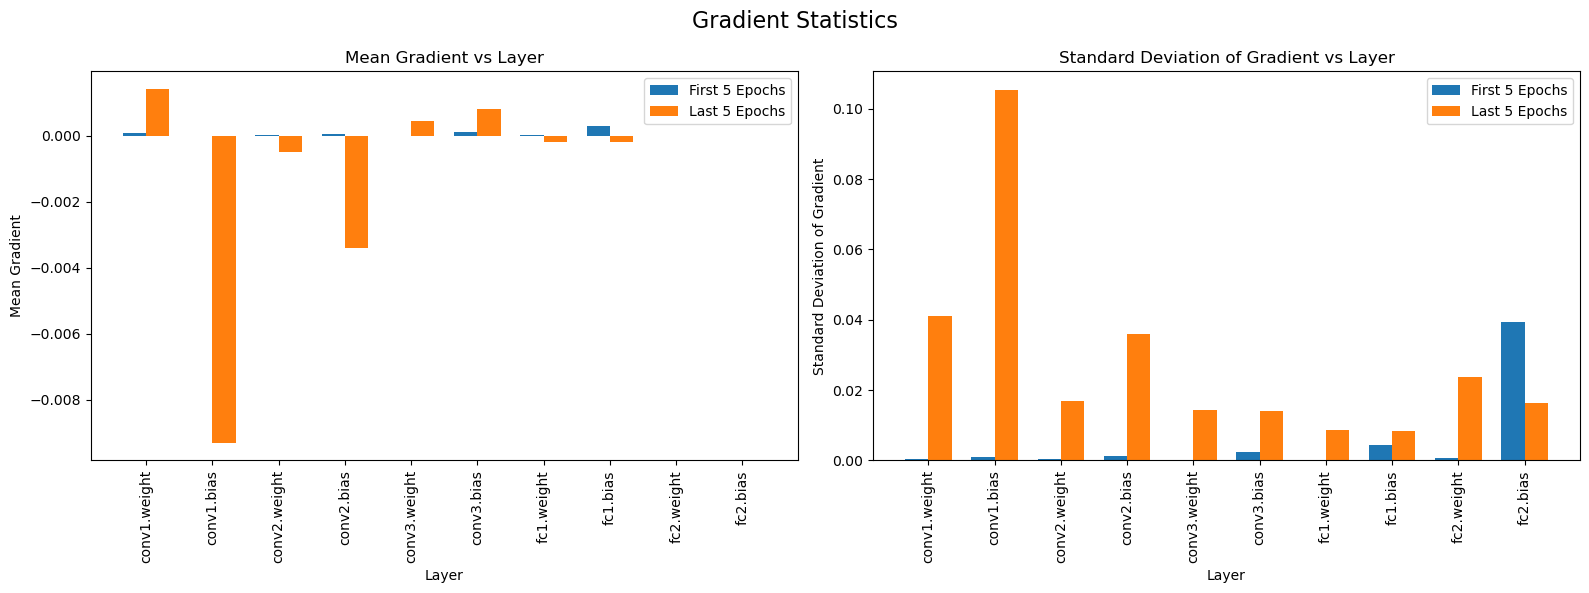

In [17]:
# get grads for BASELINE

torch.manual_seed(1984)

non_drop_model = BaselineNet()

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics(last_5_epochs_gradients_non_drop)

plot_gradient_statistics(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29


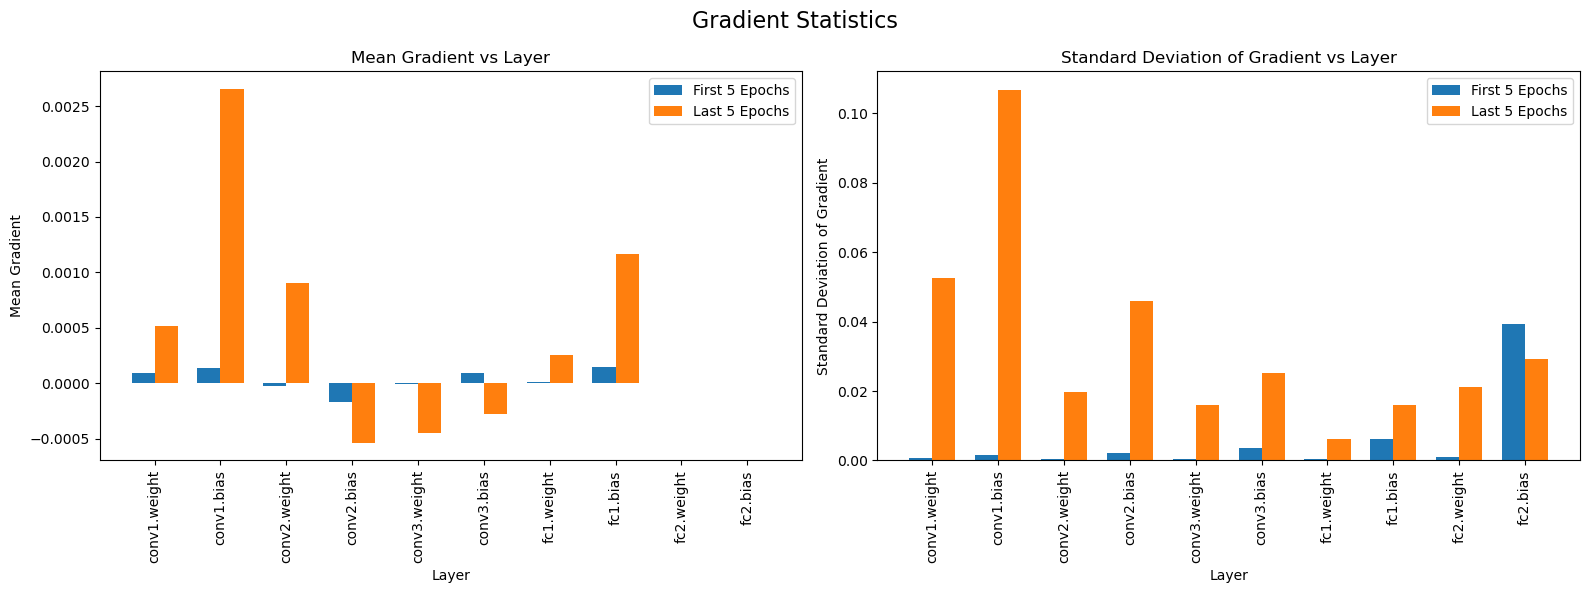

In [18]:
# get grads for DROPOUT

torch.manual_seed(1984)


drop_model = DropoutNet(0.6)

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics(last_5_epochs_gradients_dropout)

plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29


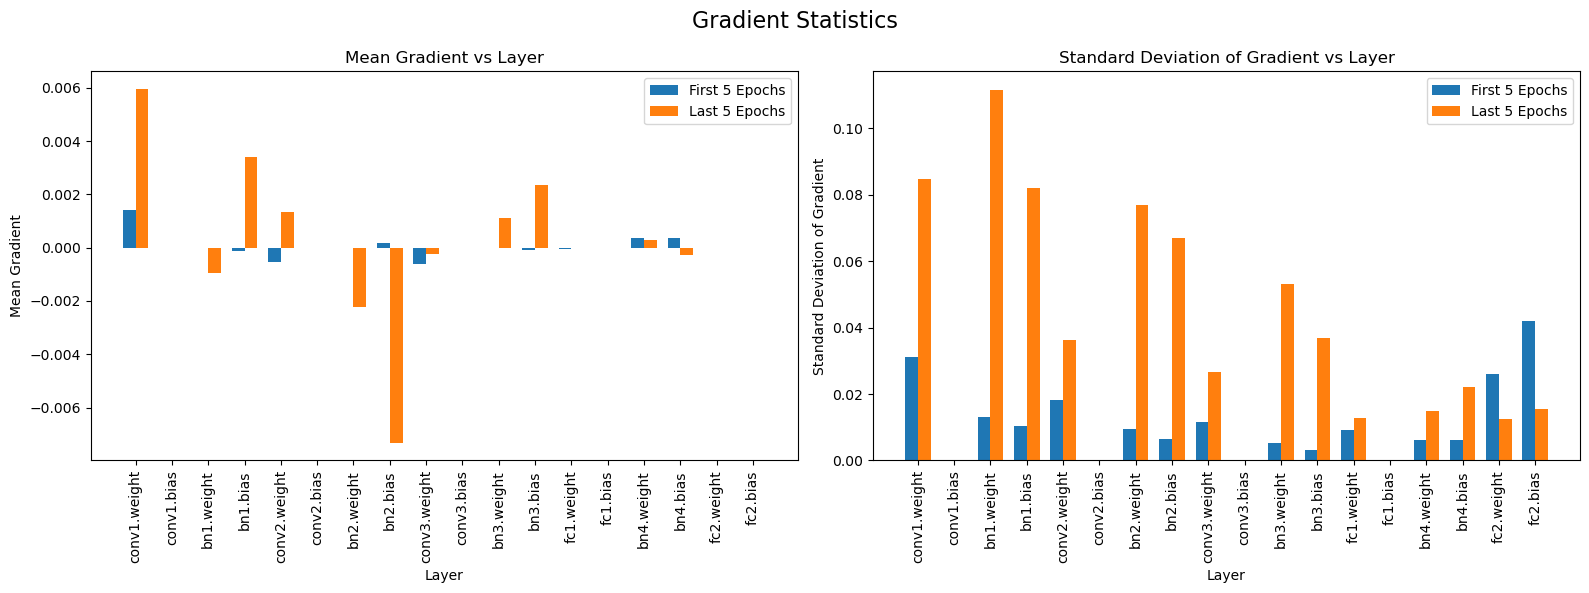

In [19]:
# get grads for BATCH NORM

torch.manual_seed(1984)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics(last_5_epochs_gradients_bn)

plot_gradient_statistics(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)

In [20]:
def collect_gradients_abs(model, dataloader, device, criterion, optimizer, num_epochs):
    first_5_episodes_gradients = {name: [] for name, _ in model.named_parameters()}
    last_5_episodes_gradients = {name: [] for name, _ in model.named_parameters()}
    
    for epoch in range(num_epochs):
        model.train().to(device)
        
        for batch_count, (images, labels) in enumerate(dataloader, 1):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            episode_gradients = {}
            for name, param in model.named_parameters():
                if param.grad is not None:
                    episode_gradients[name] = torch.abs(param.grad.clone().detach())
            
            if epoch == 0 and batch_count <= 5:
                for name, grad in episode_gradients.items():
                    first_5_episodes_gradients[name].append(grad)
            elif epoch == num_epochs - 1 and batch_count > len(dataloader) - 5:
                for name, grad in episode_gradients.items():
                    last_5_episodes_gradients[name].append(grad)
            
            optimizer.step()
    
    return first_5_episodes_gradients, last_5_episodes_gradients

def compute_gradient_statistics_abs(gradients):
    mean_gradients = {}
    std_gradients = {}
    
    for layer_name, layer_gradients in gradients.items():
        layer_gradients = torch.stack(layer_gradients)
        mean_gradients[layer_name] = torch.mean(layer_gradients, dim=0)
        std_gradients[layer_name] = torch.std(layer_gradients, dim=0)
    
    return mean_gradients, std_gradients

def plot_gradient_statistics_abs(mean_gradients_first5, std_gradients_first5, mean_gradients_last5, std_gradients_last5):
    num_layers = len(mean_gradients_first5)
    layer_names = list(mean_gradients_first5.keys())
    x = np.arange(num_layers)
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Gradient Statistics (Absolute Values)', fontsize=16)
    
    # Plot mean gradients
    ax1.bar(x - width/2, [torch.mean(mean_gradients_first5[name]).item() for name in layer_names], width, label='First 5 Epochs')
    ax1.bar(x + width/2, [torch.mean(mean_gradients_last5[name]).item() for name in layer_names], width, label='Last 5 Epochs')
    ax1.set_xticks(x)
    ax1.set_xticklabels(layer_names, rotation=45)
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Mean of Absolute Gradients')
    ax1.set_title('Mean of Absolute Gradients vs Layer')
    ax1.legend()
    
    # Plot standard deviations
    ax2.bar(x - width/2, [torch.mean(std_gradients_first5[name]).item() for name in layer_names], width, label='First 5 Epochs')
    ax2.bar(x + width/2, [torch.mean(std_gradients_last5[name]).item() for name in layer_names], width, label='Last 5 Epochs')
    ax2.set_xticks(x)
    ax2.set_xticklabels(layer_names, rotation=45)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Standard Deviation of Absolute Gradients')
    ax2.set_title('Standard Deviation of Absolute Gradients vs Layer')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

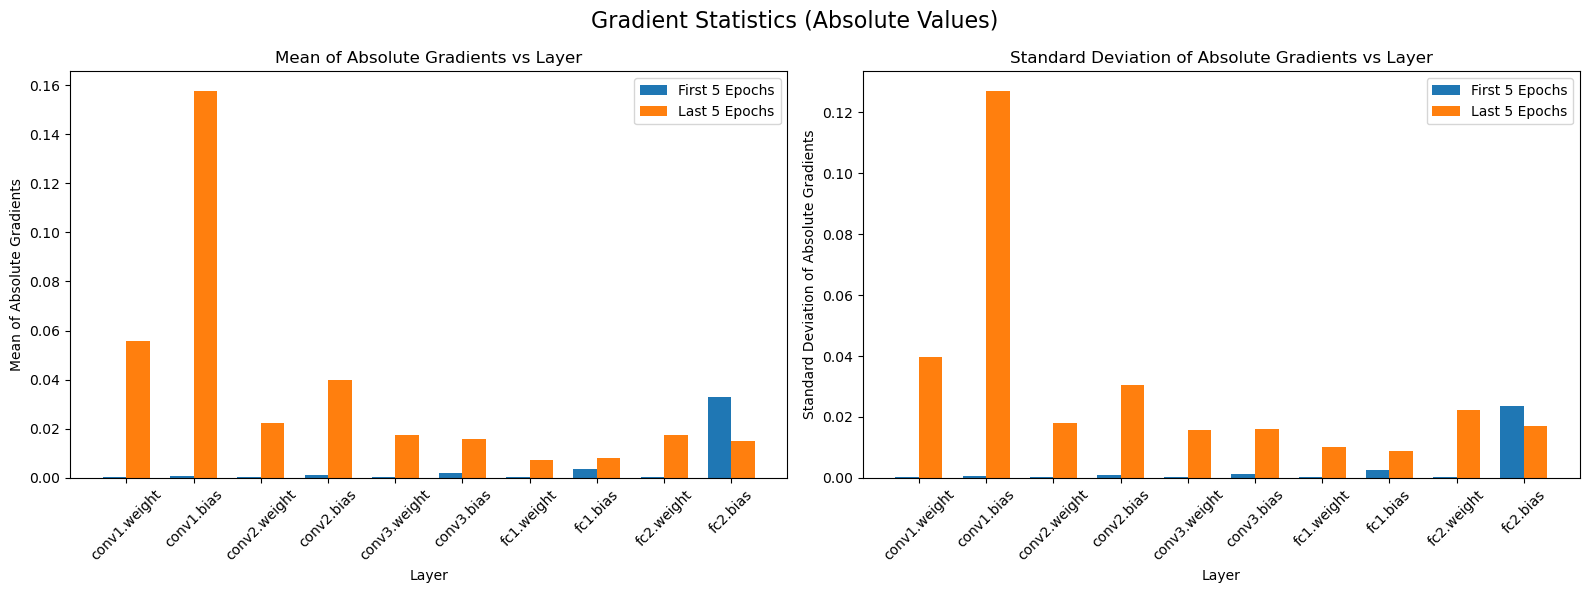

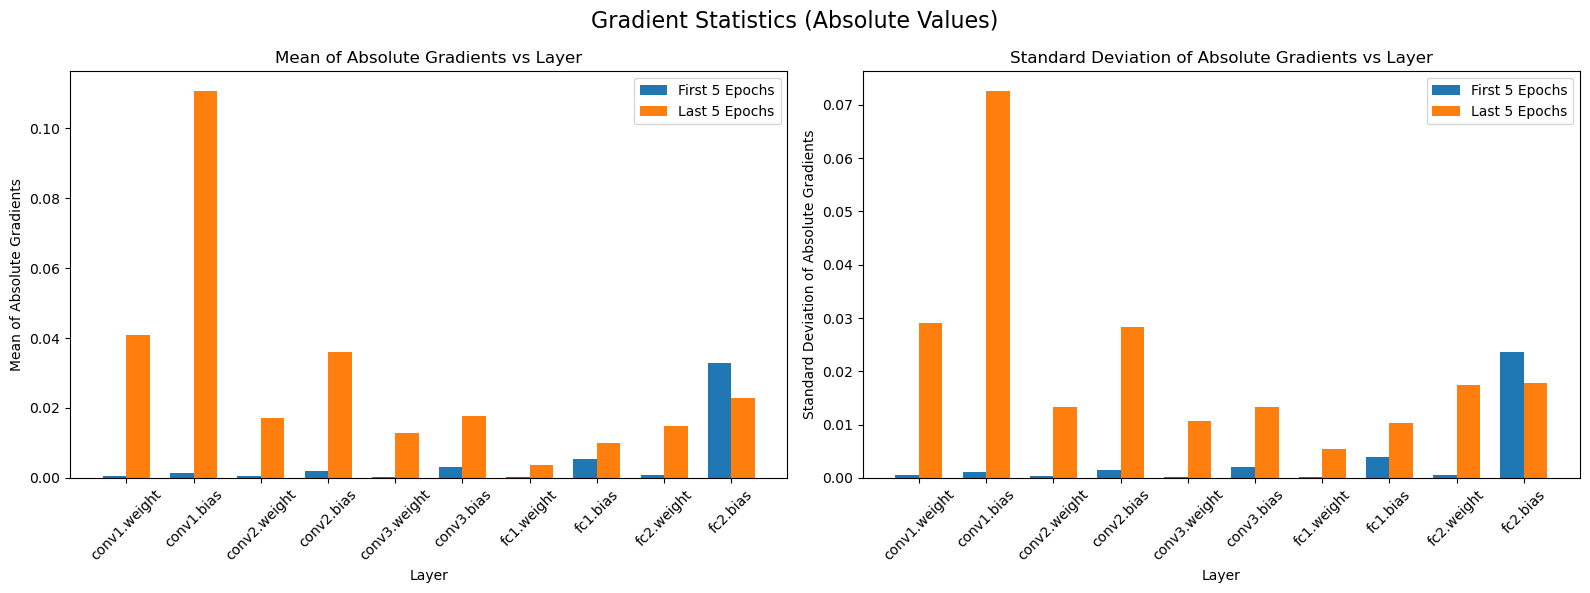

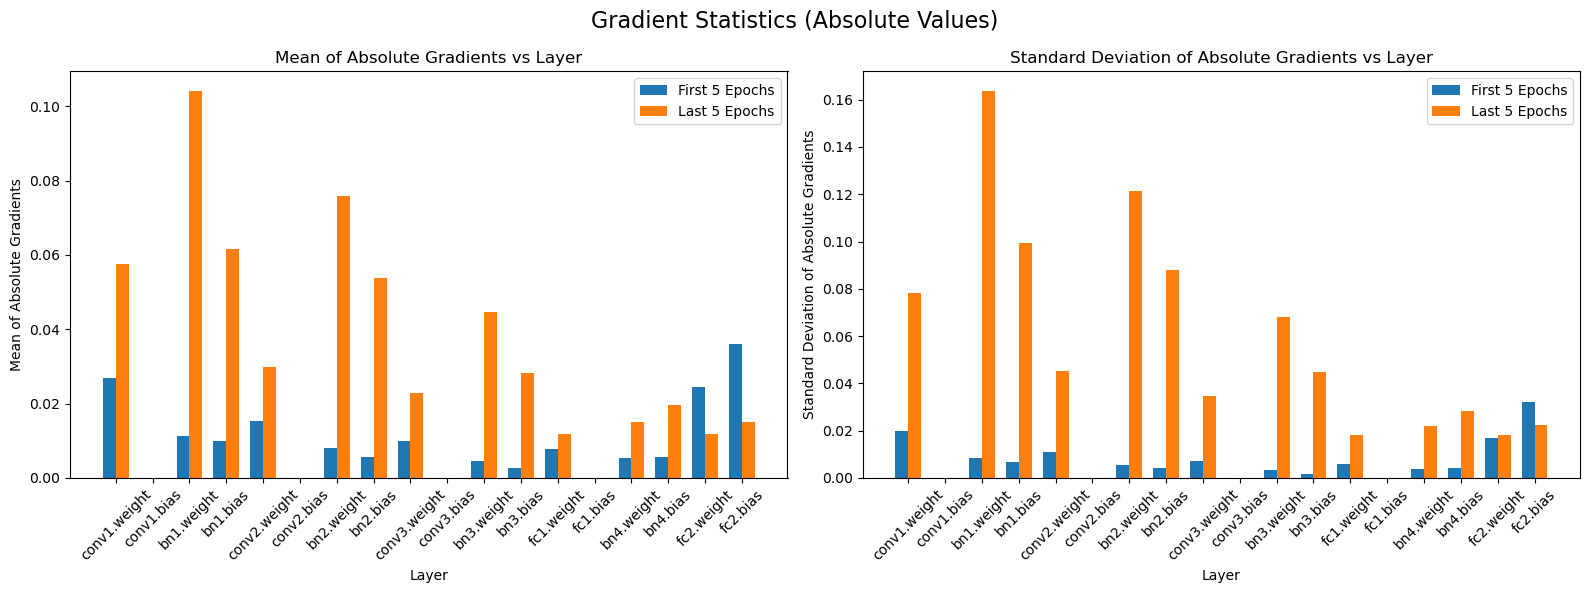

In [22]:
num_epochs = 30
learning_rate= 0.05

#Abs grad for BASELINE 
torch.manual_seed(1984)
non_drop_model = BaselineNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)
first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients_abs(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)
first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics_abs(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics_abs(last_5_epochs_gradients_non_drop)
plot_gradient_statistics_abs(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)

#Abs grad for DROPOUT
torch.manual_seed(1984)
drop_model = DropoutNet(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)
first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients_abs(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)
first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics_abs(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics_abs(last_5_epochs_gradients_dropout)
plot_gradient_statistics_abs(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

#Abs grad for BATCHNORM
torch.manual_seed(1984)
bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)
first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients_abs(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)
first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics_abs(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics_abs(last_5_epochs_gradients_bn)
plot_gradient_statistics_abs(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)

average for 


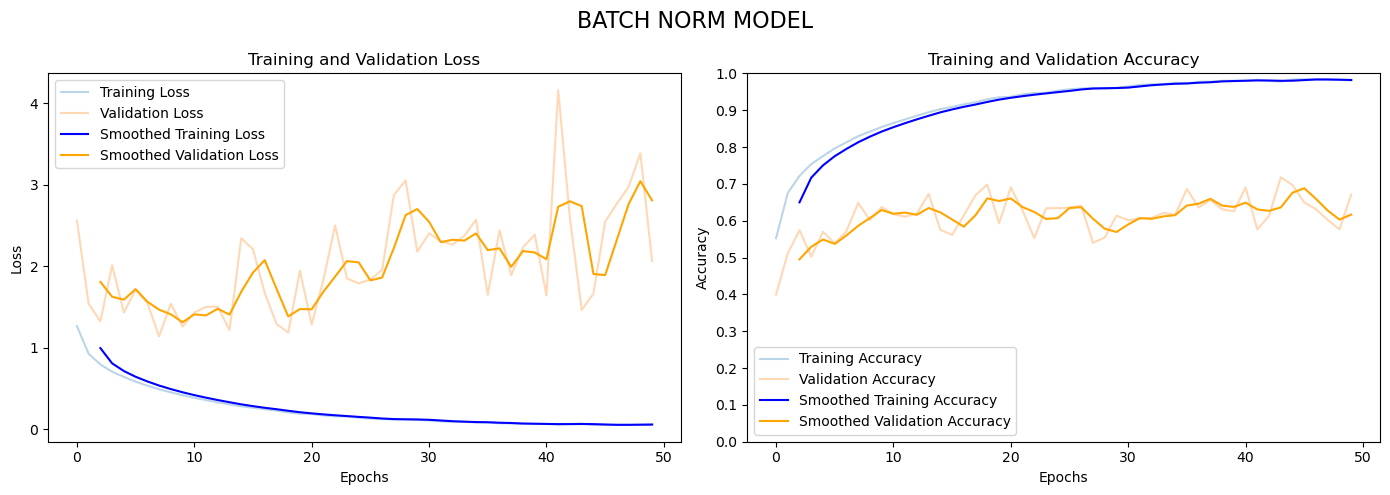

In [25]:
# propert train a batch norm model 

num_epochs = 50
learning_rate = 0.05

random_seeds = list(range(1, 6))
path_to_save = f'./run_data/batch_norm/batch_norm_{num_epochs}_epochs_LR_{learning_rate}.json'
path_to_load = f'./run_data/batch_norm/batch_norm_{num_epochs}_epochs_LR_{learning_rate}.json'
averaged_results = {'bn':{}}
save_experiment = True

# train them both on the original data

epoch_train_losses_by_run = []
epoch_val_losses_by_run = []
epoch_train_accuracies_by_run = []
epoch_val_accuracies_by_run = []
test_losses = []
test_accuracies = []
reports = []

for random_seed in random_seeds:
    print('seed:', random_seed)
    
    torch.manual_seed(random_seed)
    
    model = BatchNormNet()
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=learning_rate)
    
    model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, metrics = False, manual_lr_schedule=False, plot=True)
    epoch_train_losses_by_run.append(train_epoch_losses)
    epoch_val_losses_by_run.append(val_epoch_losses)
    epoch_train_accuracies_by_run.append(train_epoch_accuracy)
    epoch_val_accuracies_by_run.append(val_epoch_accuracy)
    
    test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    reports.append(report)
    
average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
average_test_loss = sum(test_losses)/len(test_losses)
average_test_accuracy = sum(test_accuracies)/len(test_accuracies)

averaged_results['bn'] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                    'av_val_losses': average_val_losses,
                                    'av_train_acc': average_train_accuracies,
                                    'av_val_acc': average_val_accuracies,
                                    'all_train_losses':epoch_train_losses_by_run,
                                    'all_val_losses': epoch_val_losses_by_run,
                                    'all_train_accuracies': epoch_train_accuracies_by_run,
                                    'all_val_accuracies': epoch_val_accuracies_by_run,
                                    'all_test_losses':test_losses, 
                                    'all_test_accuracies':test_accuracies,
                                    'av_test_loss': average_test_loss,
                                    'av_test_accuracy':average_test_accuracy}
print('average for ')
plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'BATCH NORM MODEL')

    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read

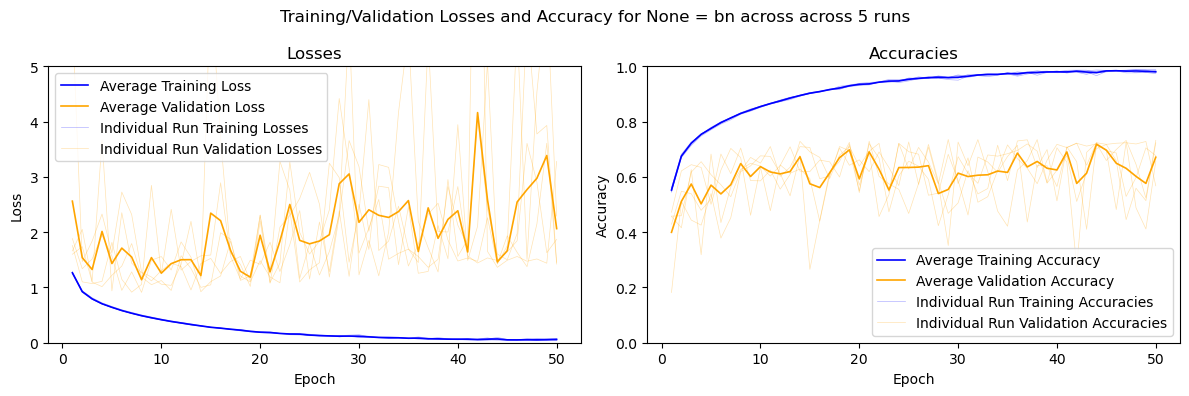

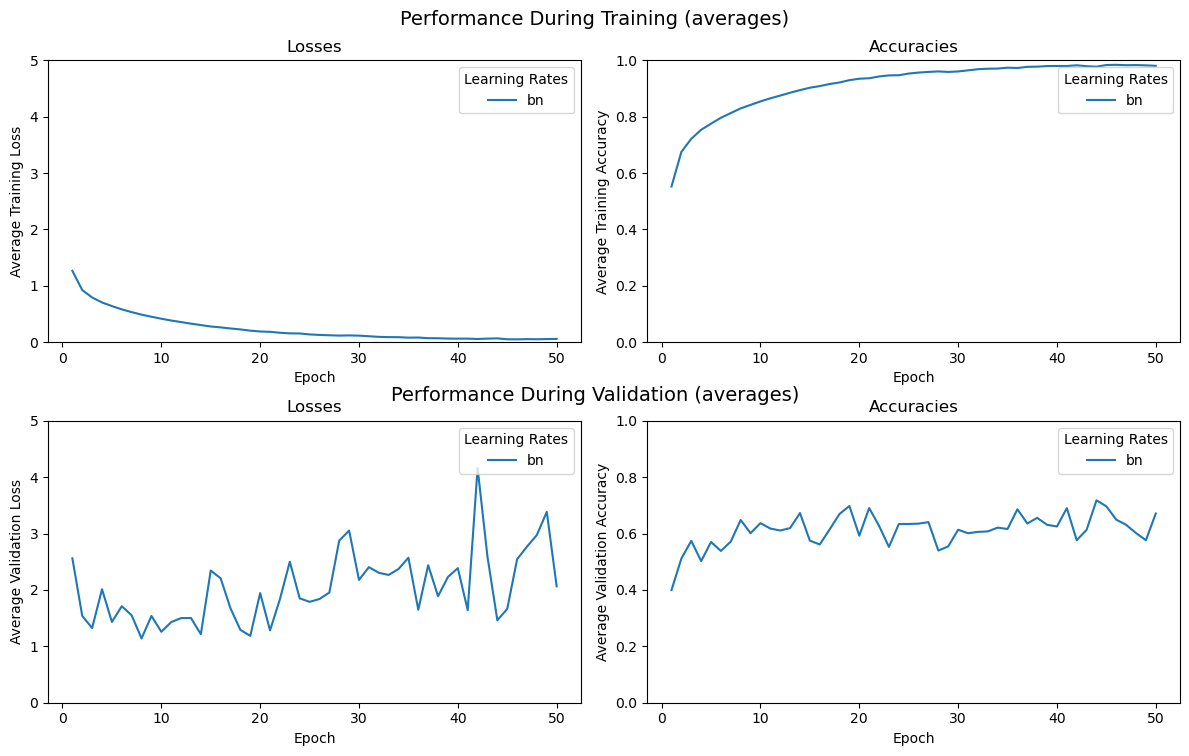

hi


,Average Test Loss,Average Test Accuracy
bn,2.093492,0.670442


In [30]:
batch_norm = 'run_data/batch_norm/batch_norm_50_epochs_LR_0.05.json'
plot_all_models_performance_from_disk(batch_norm, enforce_axis=True)
plot_performance_comparison_from_file(batch_norm, enforce_axis=True)
display_accuracy_heatmap(batch_norm)

seed: 1
LR: 0.05
Epoch [1/50] - Train Loss: 1.2684, Acc: 0.5526 | Val Loss: 1.7836, Acc: 0.4335
LR: 0.04
Epoch [2/50] - Train Loss: 0.9160, Acc: 0.6782 | Val Loss: 1.6278, Acc: 0.4765
LR: 0.03333333333333333
Epoch [3/50] - Train Loss: 0.7779, Acc: 0.7284 | Val Loss: 1.2213, Acc: 0.6060
LR: 0.028571428571428574
Epoch [4/50] - Train Loss: 0.6850, Acc: 0.7597 | Val Loss: 1.2936, Acc: 0.5761
LR: 0.025
Epoch [5/50] - Train Loss: 0.6201, Acc: 0.7845 | Val Loss: 0.8856, Acc: 0.6984
LR: 0.022222222222222223
Epoch [6/50] - Train Loss: 0.5604, Acc: 0.8064 | Val Loss: 0.9477, Acc: 0.6739
LR: 0.02
Epoch [7/50] - Train Loss: 0.5161, Acc: 0.8224 | Val Loss: 1.2168, Acc: 0.6228
LR: 0.018181818181818184
Epoch [8/50] - Train Loss: 0.4757, Acc: 0.8376 | Val Loss: 1.0535, Acc: 0.6559
LR: 0.016666666666666666
Epoch [9/50] - Train Loss: 0.4367, Acc: 0.8497 | Val Loss: 0.8698, Acc: 0.7150
LR: 0.015384615384615385
Epoch [10/50] - Train Loss: 0.4025, Acc: 0.8644 | Val Loss: 0.9053, Acc: 0.7164
LR: 0.014285714

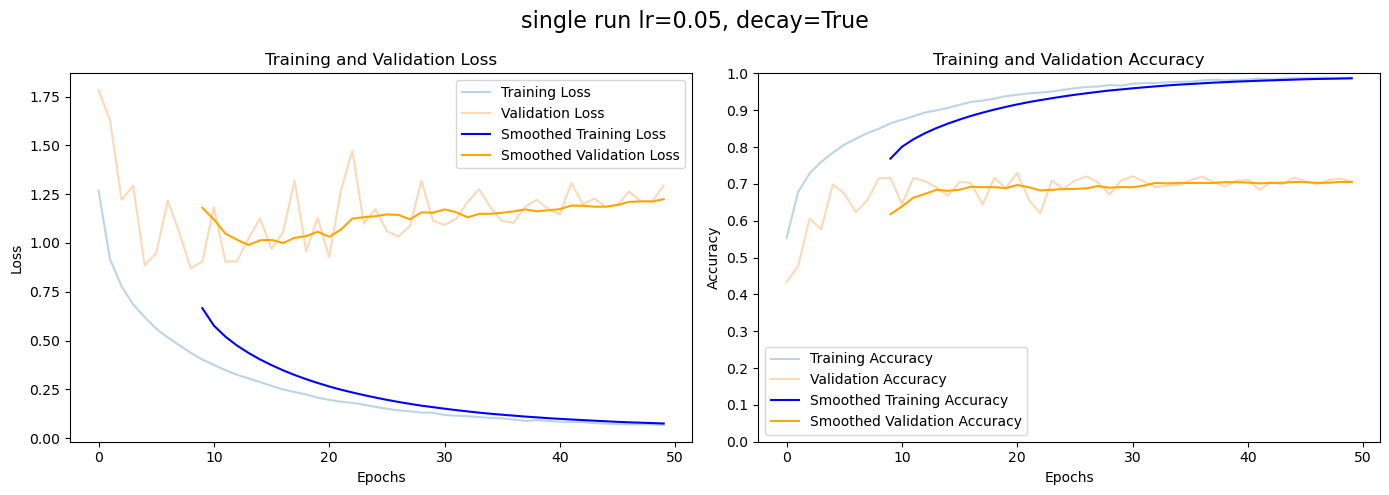

TESTING COMPLETE!!
Test Loss: 1.2319, Test Acc: 0.7098
              precision    recall  f1-score   support

       plane       0.79      0.71      0.75      1000
         car       0.84      0.84      0.84      1000
        bird       0.59      0.63      0.61      1000
         cat       0.52      0.54      0.53      1000
        deer       0.75      0.56      0.64      1000
         dog       0.62      0.59      0.60      1000
        frog       0.64      0.88      0.74      1000
       horse       0.82      0.72      0.77      1000
        ship       0.81      0.81      0.81      1000
       truck       0.79      0.81      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

seed: 2
LR: 0.05
Epoch [1/50] - Train Loss: 1.2505, Acc: 0.5609 | Val Loss: 1.3119, Acc: 0.5411
LR: 0.04
Epoch [2/50] - Train Loss: 0.8974, Acc: 0.6857 | Val Loss: 1.3157, Acc: 0.5506
LR

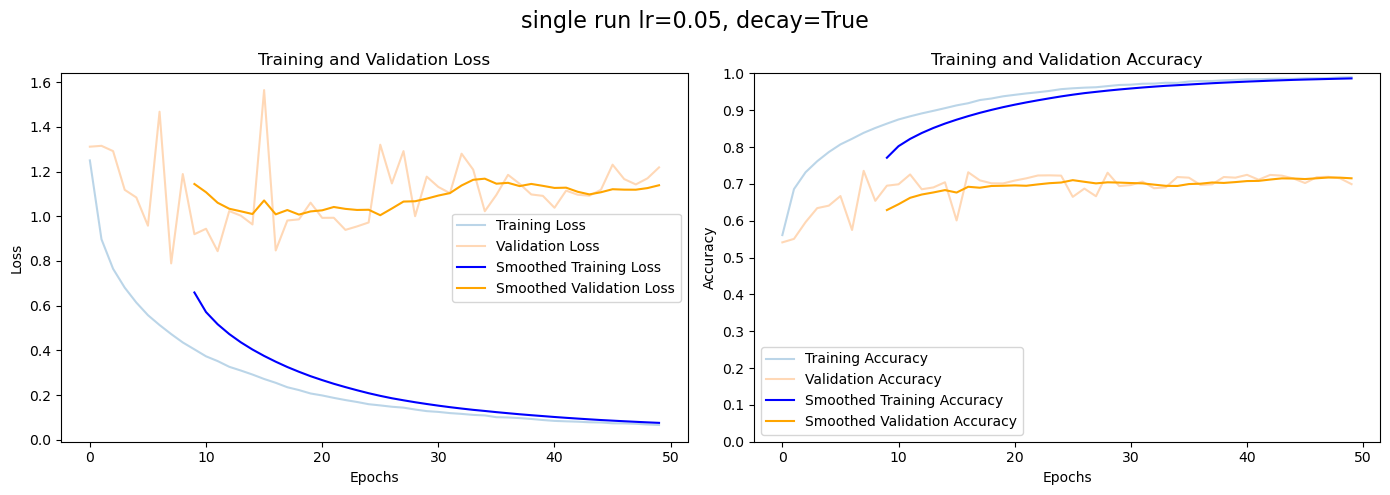

TESTING COMPLETE!!
Test Loss: 1.2153, Test Acc: 0.7067
              precision    recall  f1-score   support

       plane       0.74      0.76      0.75      1000
         car       0.70      0.91      0.79      1000
        bird       0.68      0.52      0.59      1000
         cat       0.53      0.53      0.53      1000
        deer       0.70      0.62      0.66      1000
         dog       0.56      0.70      0.62      1000
        frog       0.81      0.74      0.77      1000
       horse       0.78      0.69      0.73      1000
        ship       0.81      0.83      0.82      1000
       truck       0.79      0.77      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000

seed: 3
LR: 0.05
Epoch [1/50] - Train Loss: 1.2783, Acc: 0.5473 | Val Loss: 3.7346, Acc: 0.2468
LR: 0.04
Epoch [2/50] - Train Loss: 0.9101, Acc: 0.6809 | Val Loss: 1.4690, Acc: 0.5241
LR

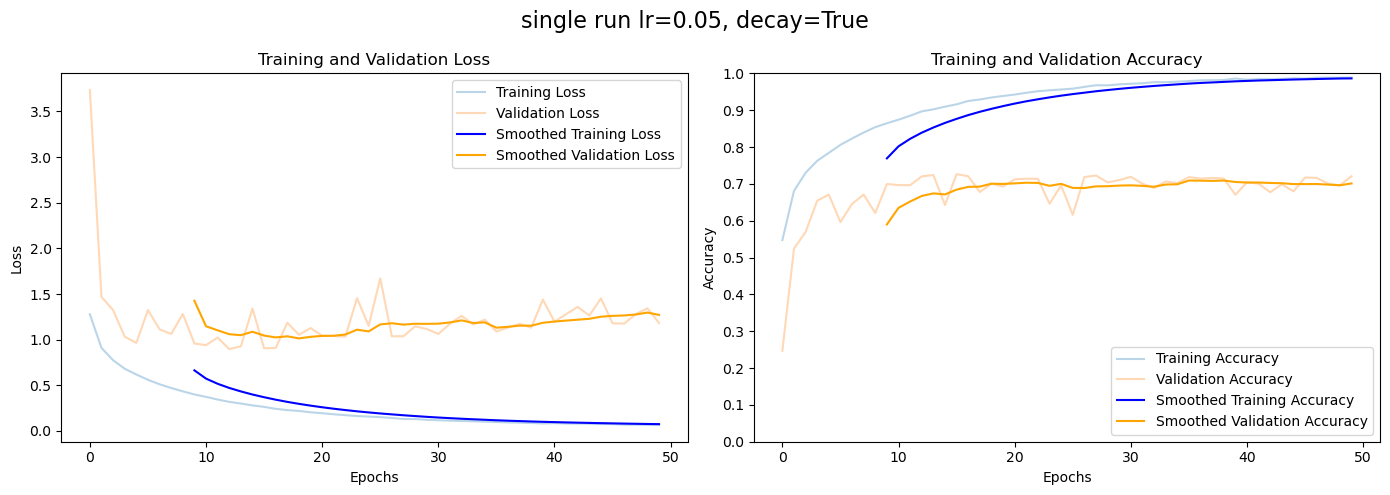

TESTING COMPLETE!!
Test Loss: 1.1493, Test Acc: 0.7211
              precision    recall  f1-score   support

       plane       0.76      0.76      0.76      1000
         car       0.82      0.83      0.82      1000
        bird       0.63      0.62      0.63      1000
         cat       0.55      0.51      0.53      1000
        deer       0.66      0.71      0.68      1000
         dog       0.61      0.64      0.62      1000
        frog       0.78      0.78      0.78      1000
       horse       0.79      0.75      0.77      1000
        ship       0.82      0.84      0.83      1000
       truck       0.79      0.79      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

seed: 4
LR: 0.05
Epoch [1/50] - Train Loss: 1.2526, Acc: 0.5607 | Val Loss: 1.3040, Acc: 0.5451
LR: 0.04
Epoch [2/50] - Train Loss: 0.9009, Acc: 0.6830 | Val Loss: 1.4688, Acc: 0.5346
LR

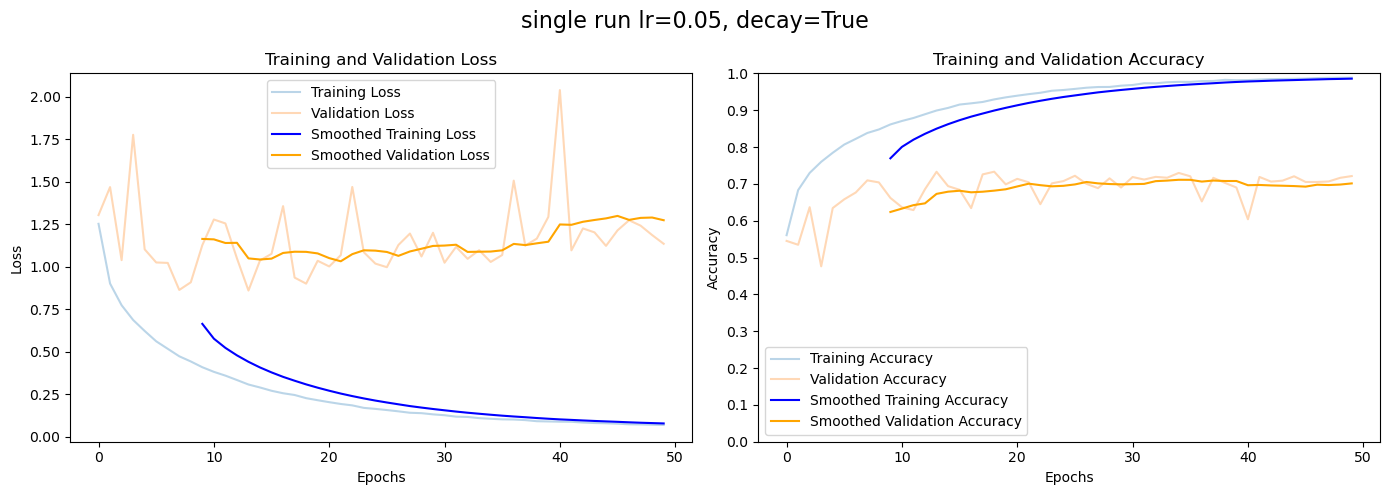

TESTING COMPLETE!!
Test Loss: 1.1487, Test Acc: 0.7257
              precision    recall  f1-score   support

       plane       0.71      0.79      0.75      1000
         car       0.85      0.83      0.84      1000
        bird       0.63      0.62      0.62      1000
         cat       0.54      0.53      0.53      1000
        deer       0.70      0.69      0.69      1000
         dog       0.63      0.63      0.63      1000
        frog       0.79      0.77      0.78      1000
       horse       0.78      0.76      0.77      1000
        ship       0.82      0.83      0.83      1000
       truck       0.82      0.80      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

seed: 5
LR: 0.05
Epoch [1/50] - Train Loss: 1.2672, Acc: 0.5481 | Val Loss: 1.7916, Acc: 0.4163
LR: 0.04
Epoch [2/50] - Train Loss: 0.9293, Acc: 0.6717 | Val Loss: 1.5043, Acc: 0.5049
LR

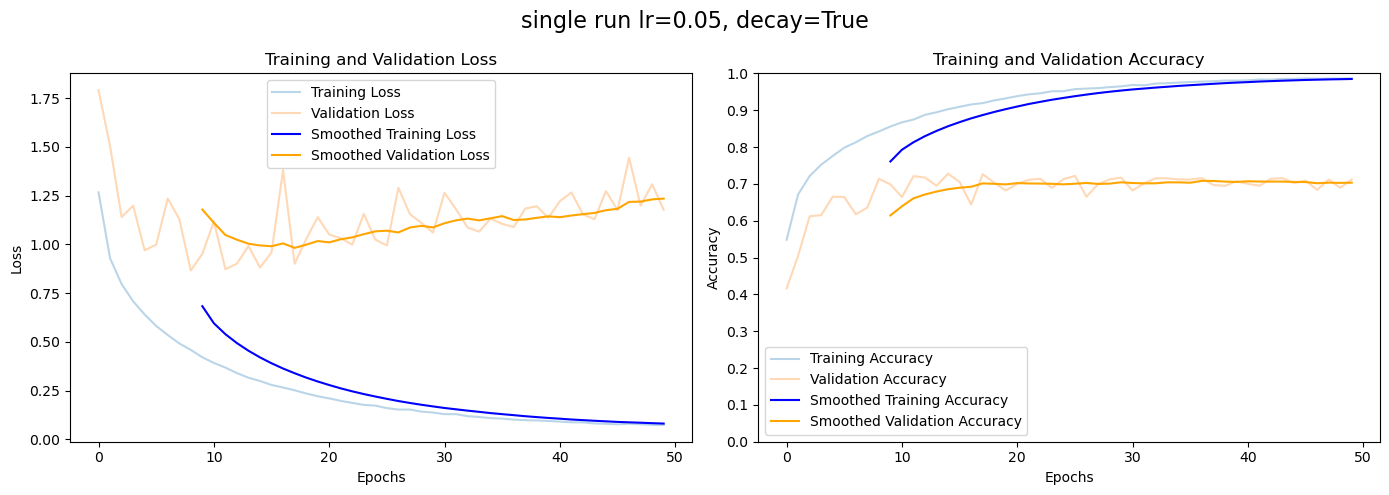

TESTING COMPLETE!!
Test Loss: 1.1577, Test Acc: 0.7108
              precision    recall  f1-score   support

       plane       0.73      0.77      0.75      1000
         car       0.85      0.80      0.82      1000
        bird       0.62      0.61      0.61      1000
         cat       0.50      0.56      0.53      1000
        deer       0.68      0.63      0.66      1000
         dog       0.62      0.60      0.61      1000
        frog       0.74      0.81      0.77      1000
       horse       0.79      0.73      0.76      1000
        ship       0.80      0.83      0.82      1000
       truck       0.80      0.77      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

average for 


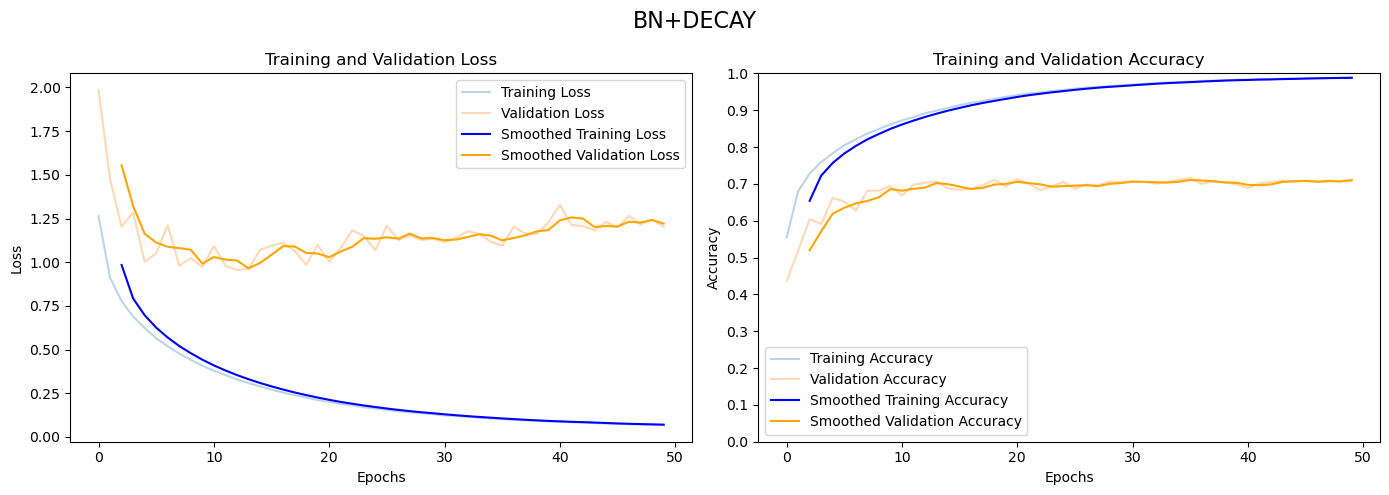

In [26]:
# EXTRA = BATCH NORM + rate decay

def adjust_initial_learning_rate(optimiser, epoch, initial_lr=0.05, decay_rate=0.25):    
    new_lr = initial_lr / (1 + decay_rate *epoch)
    for param_group in optimiser.param_groups:
        param_group['lr'] = new_lr
    print('LR:',new_lr)
    return optimiser

num_epochs = 50
initial_learning_rate = 0.05

random_seeds = list(range(1, 6))

averaged_results = {'bn_plus_decay':{}}

path_to_save = f'./run_data/batch_norm/batch_norm_with_decay_lr_{initial_learning_rate}_{num_epochs}_epochs.json'
path_to_load = f'./run_data/batch_norm/batch_norm_with_decay_lr_{initial_learning_rate}_{num_epochs}_epochs.json'
save_experiment = True


epoch_train_losses_by_run = []
epoch_val_losses_by_run = []
epoch_train_accuracies_by_run = []
epoch_val_accuracies_by_run = []
test_losses = []
test_accuracies = []
reports = []

for random_seed in random_seeds:
    print('seed:', random_seed)
    torch.manual_seed(random_seed)
    
    model = BatchNormNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=initial_learning_rate)

    model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, initial_learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, metrics = False, manual_lr_schedule=True,scheduler_func=adjust_initial_learning_rate,  plot=True)
    epoch_train_losses_by_run.append(train_epoch_losses)
    epoch_val_losses_by_run.append(val_epoch_losses)
    epoch_train_accuracies_by_run.append(train_epoch_accuracy)
    epoch_val_accuracies_by_run.append(val_epoch_accuracy)
    
    test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    reports.append(report)
    
average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
average_test_loss = sum(test_losses)/len(test_losses)
average_test_accuracy = sum(test_accuracies)/len(test_accuracies)

averaged_results['bn_plus_decay'] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                    'av_val_losses': average_val_losses,
                                    'av_train_acc': average_train_accuracies,
                                    'av_val_acc': average_val_accuracies,
                                    'all_train_losses':epoch_train_losses_by_run,
                                    'all_val_losses': epoch_val_losses_by_run,
                                    'all_train_accuracies': epoch_train_accuracies_by_run,
                                    'all_val_accuracies': epoch_val_accuracies_by_run,
                                    'all_test_losses':test_losses, 
                                    'all_test_accuracies':test_accuracies,
                                    'av_test_loss': average_test_loss,
                                    'av_test_accuracy':average_test_accuracy}
print('average for ')
plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'BN+DECAY')

if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read


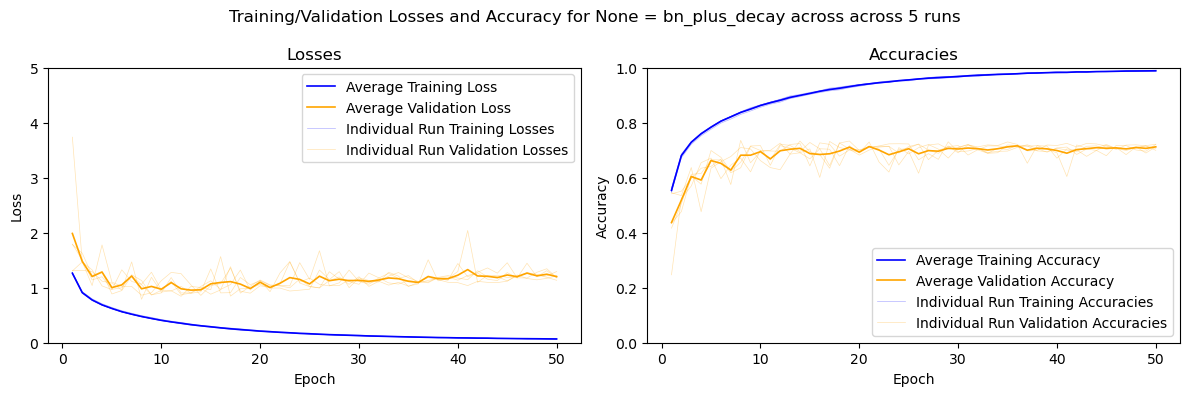

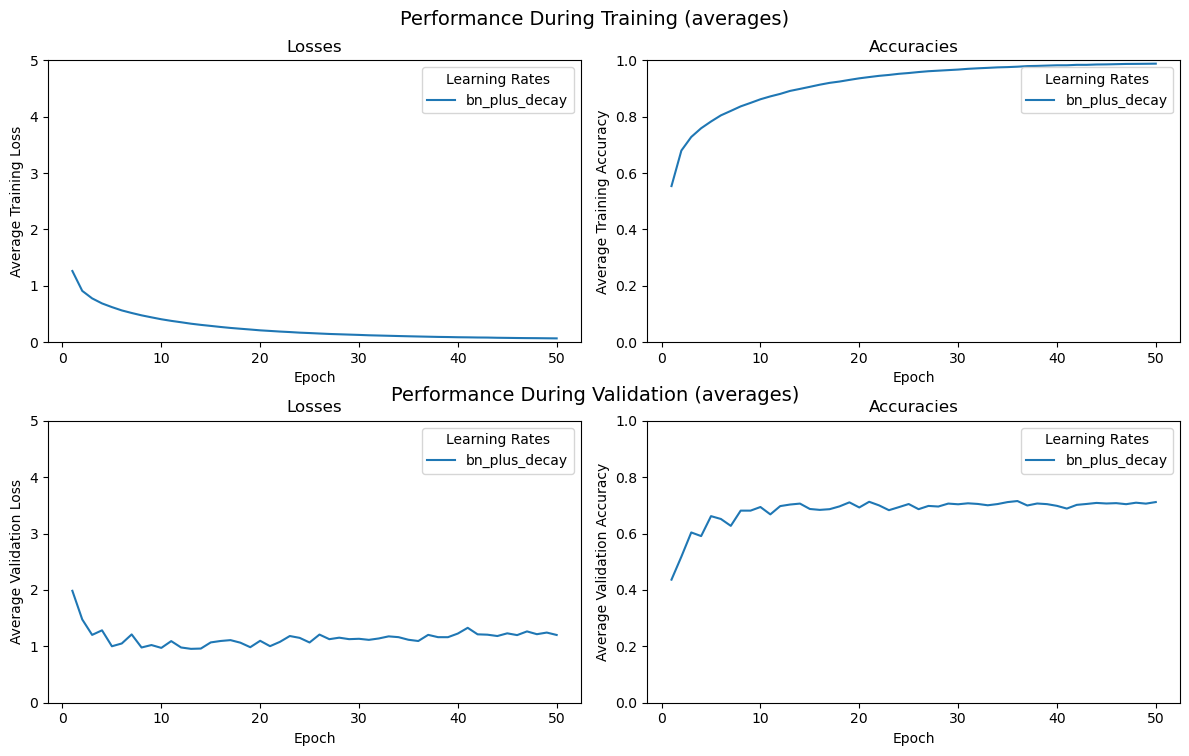

hi


,Average Test Loss,Average Test Accuracy
bn_plus_decay,1.180587,0.714829


In [28]:
batch_norm_with_decay = 'run_data/batch_norm/batch_norm_with_decay_lr_0.05_50_epochs.json'
plot_all_models_performance_from_disk(batch_norm_with_decay, enforce_axis=True)
plot_performance_comparison_from_file(batch_norm_with_decay, enforce_axis=True)
display_accuracy_heatmap(batch_norm_with_decay)